# 数据科学毕业项目（量化投资）~ 分析思路

## 1、 套利定价理论（因子选择）

1.1 套利定价理论（APT）进行多元线性分析，选出对证券收益最有影响的因子。

1.2 可能有影响的因子约有100个左右，使用最小二乘法或岭回归不断减少因子，得出最有效的因子。

1.3 按选出的因子进行预测，得到可能效果最佳的证券组合

## 2、现代资产组合理论（组合优化）

2.1 正态性检验

2.2 Sharp优化，方差优化

In [115]:
#加载需要的库
import datetime as dt
import math
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
# 导入多元线性规划需要的工具包
import statsmodels.api as sm
from statsmodels import regression
import scipy.stats as scs
import matplotlib.pyplot as plt

#最优化投资组合的推导是一个约束最优化问题
import scipy.optimize as sco

# 一、套利定价理论（APT）

套利定价理论APT(Arbitrage Pricing Theory) 是认为是市场上风险资产均衡收益与多个因素之间存在（近似的）线性关系。

套利定价理论是资本资产定价模型（CAPM）的拓广，由APT给出的定价模型与CAPM一样，都是均衡状态下的模型，不同的是APT的基础是因素模型。

套利定价理论认为，套利行为是现代有效率市场（即市场均衡价格）形成的一个决定因素。如果市场未达到均衡状态的话，市场上就会存在无风险套利机会。 并且用多个因素来解释风险资产收益，并根据无套利原则，得到风险资产均衡收益与多个因素之间存在（近似的）线性关系。 



1.1 基础设定

1.1.1 股票池：我们选择沪深300指数的全部成份股票来进行分析，假定每一个因子对沪深300成份股票的作用相同。（可以按不同行业、不同特征或其它指数成份股票进行分析）

1.1.2 调仓周期：由于公司财务数据是按季来进行公布，我们将按季度来进行回归分析、选股、并调整仓位。分别为2月、5月、8月、11月的第一天。

1.1.3 回归方式：我们将一年内的4个季度财报数据与公告后3个月内的价格变动进行回归。

1.1.4 预测调仓：我们预测出可能收益最佳的前10个股票进行持仓。并与沪深300指数进行对比。


In [28]:
#获得沪深300股票池
stocks = get_index_stocks('000300.XSHG')
#取得2015年的4期财报数据。并按财报后3个月的证券价格来计算收益
periods = ['2015-02-01','2015-05-01','2015-08-01','2015-11-01']

In [29]:
df_stock_data = pd.DataFrame()

for stock in stocks:
    for period in periods:
        #按沪深300和不同的日期表来查询数据
        q = query(valuation,balance,cash_flow,income,indicator).filter(indicator.code.in_([stock]))
        f_temp=get_fundamentals(q,period)
        #得到90个自然日后的价格
        next_period_day = dt.datetime.strptime(period,'%Y-%m-%d')  + dt.timedelta(days = 90)
        df_next_price = get_price(stock, start_date=period, end_date=next_period_day, frequency='daily', fields=['close'])
        #选出约1个季度后的价格的数据。
        f_temp['return'] = df_next_price['close'][-1]
        df_stock_data = df_stock_data.append(f_temp)
#写入本地数据CSV表 
write_file('csv_data/df_all_factors.csv', df_stock_data.to_csv())       

df_stock_data.head()



#最后代入2016年2月1日的因子数据，来预测一下5月1日的收益看看结果如何？


,id,code,pe_ratio,turnover_ratio,pb_ratio,ps_ratio,pcf_ratio,capitalization,market_cap,circulating_cap,...,inc_total_revenue_annual,inc_revenue_year_on_year,inc_revenue_annual,inc_operation_profit_year_on_year,inc_operation_profit_annual,inc_net_profit_year_on_year,inc_net_profit_annual,inc_net_profit_to_shareholders_year_on_year,inc_net_profit_to_shareholders_annual,return
0,2447,000001.XSHE,8.28,0.95,1.22,2.29,11.07,1142489,1591.49,983671,...,6.90,43.10,6.90,37.19,11.96,34.98,12.04,34.98,12.04,13.71
0,2505,000001.XSHE,11.24,2.45,1.67,2.94,-4.40,1370987,2289.55,1180405,...,10.21,28.39,10.21,10.95,36.02,11.38,37.03,11.38,37.03,10.07
0,2569,000001.XSHE,8.68,1.02,1.17,2.27,-3.40,1430868,1768.55,1180405,...,10.21,28.39,10.21,10.95,36.02,11.38,37.03,11.38,37.03,9.33
0,5057845,000001.XSHE,7.44,0.45,1.03,1.81,0.75,1430868,1625.47,1180405,...,-5.12,23.39,-5.12,8.24,2.79,9.48,3.34,9.48,3.34,8.21
0,5062,000002.XSHE,9.39,2.16,1.64,1.07,12.19,1103751,1448.12,970668,...,-29.52,0.69,-29.52,-5.72,-44.17,-1.34,-45.19,2.80,-49.73,14.11


In [30]:
#设置一些备选的因子
factors=['eps','adjusted_profit','inc_return','operation_profit_to_total_revenue','net_profit_margin',\
         'gross_profit_margin','ga_expense_to_total_revenue','goods_sale_and_service_to_revenue',\
         'pb_ratio','pe_ratio','market_cap','ps_ratio','inc_total_revenue_year_on_year'] 

returns = ['return']

df_factor = pd.read_csv('../csv_data/df_all_factors.csv')

df_select_factor = df_factor[factors+returns]

df_select_factor = df_select_factor.dropna()

df_select_factor.head()



,eps,adjusted_profit,inc_return,operation_profit_to_total_revenue,net_profit_margin,gross_profit_margin,ga_expense_to_total_revenue,goods_sale_and_service_to_revenue,pb_ratio,pe_ratio,market_cap,ps_ratio,inc_total_revenue_year_on_year,return
4,0.1500,1.641616e+09,2.11,12.18,9.53,28.49,3.08,181.35,1.64,9.39,1448.12,1.07,0.69,14.11
5,0.0590,6.286652e+08,0.71,13.15,10.21,34.00,8.01,358.62,1.81,10.85,1612.73,1.11,-6.35,14.08
6,0.0590,6.286652e+08,0.71,13.15,10.21,34.00,8.01,358.62,1.80,10.54,1566.72,1.07,-6.35,13.67
7,0.1800,1.850525e+09,2.09,12.39,9.37,26.67,2.89,162.29,1.70,9.36,1510.48,0.93,32.25,24.43
8,0.0202,3.159987e+04,0.00,9.29,8.96,36.21,13.81,98.67,6.00,81.15,196.73,4.97,-2.69,22.34


In [31]:
#将财报数据与收益来进行回归。得到多元线性参数，并去掉一些多余因子。
X=sm.add_constant(df_select_factor[factors])
# 进行多元线性回归
results = regression.linear_model.OLS(df_select_factor['return'], X).fit()
# 多元线性回归的参数值
print results.params

const                                7.941747e+00
eps                                  4.956643e+01
adjusted_profit                     -1.524627e-09
inc_return                          -9.299685e-01
operation_profit_to_total_revenue   -2.665825e-02
net_profit_margin                   -4.743561e-03
gross_profit_margin                  2.888978e-02
ga_expense_to_total_revenue          2.526062e-01
goods_sale_and_service_to_revenue   -2.567983e-02
pb_ratio                             1.050039e+00
pe_ratio                            -6.136674e-05
market_cap                           7.655626e-04
ps_ratio                             1.857757e-03
inc_total_revenue_year_on_year      -2.000187e-03
dtype: float64


In [32]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     117.7
Date:                Mon, 04 Jul 2016   Prob (F-statistic):          2.38e-190
Time:                        15:48:11   Log-Likelihood:                -3885.3
No. Observations:                1003   AIC:                             7799.
Df Residuals:                     989   BIC:                             7867.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
const 

In [33]:
#将一些P值高的因子全部去掉
factors=['eps','adjusted_profit','inc_return','ga_expense_to_total_revenue','goods_sale_and_service_to_revenue',\
         'pb_ratio','market_cap'] 

returns = ['return']

df_factor = pd.read_csv('../csv_data/df_all_factors.csv')

df_select_factor = df_factor[factors+returns]

df_select_factor = df_select_factor.dropna()

X=sm.add_constant(df_select_factor[factors])
# 进行多元线性回归
results = regression.linear_model.OLS(df_select_factor['return'], X).fit()
# 多元线性回归的参数值
print results.params

print(results.summary())

const                                8.223522e+00
eps                                  4.948640e+01
adjusted_profit                     -1.487166e-09
inc_return                          -1.049181e+00
ga_expense_to_total_revenue          2.546132e-01
goods_sale_and_service_to_revenue   -2.424908e-02
pb_ratio                             1.083129e+00
market_cap                           7.616721e-04
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     216.5
Date:                Mon, 04 Jul 2016   Prob (F-statistic):          2.31e-195
Time:                        15:48:11   Log-Likelihood:                -3909.2
No. Observations:                1008   AIC:                             7834.
Df Residuals:                   

In [79]:
#得到2016年02-01的因子数据,用来预测下三个月的收益表现
df_current_data = pd.DataFrame(columns = df_stock_data.columns)
for stock in stocks:
    q = query(valuation,balance,cash_flow,income,indicator).filter(indicator.code.in_([stock]))
    f_temp=get_fundamentals(q,'2016-02-01')    
    df_current_data = df_current_data.append(f_temp) 

df_current_data.head()



,account_receivable,accounts_payable,adjusted_profit,adjusted_profit_to_profit,administration_expense,advance_payment,advance_peceipts,asset_impairment_loss,basic_eps,bill_receivable,...,total_operating_revenue,total_owner_equities,total_profit,total_sheet_owner_equities,trading_assets,trading_liability,treasury_stock,turnover_ratio,value_change_profit,withdraw_insurance_contract_reserve
0,7120000000,NaN,6162999808,100.13,NaN,NaN,NaN,7.012000e+09,0.4300,NaN,...,24576999424,1.571360e+11,8026999808,2.599060e+12,NaN,NaN,NaN,0.35,933000000,NaN
0,1508193152,76799524864,1850524544,92.15,846247808,53028450304,2.313541e+11,3.088637e+07,0.1800,NaN,...,29329412096,1.211252e+11,3717434112,5.707934e+11,NaN,NaN,160148512,0.00,565417344,NaN
0,929522560,1236692864,-13388737,-2.38,160198288,157006496,4.686486e+08,7.425298e+06,0.3530,504332704,...,1141459712,6.477674e+09,829592256,1.666131e+10,NaN,NaN,NaN,4.66,838318144,NaN
0,2985187840,2108518528,546559424,97.18,188293344,831931520,4.507655e+08,-6.470810e+03,0.1419,23570000,...,3187848960,2.365507e+10,831129152,4.631445e+10,NaN,NaN,NaN,0.74,136012656,0
0,12853171200,9380634624,323492992,156.73,903224000,3983866880,3.432821e+09,7.814700e+07,0.0759,970595968,...,12633858048,3.108730e+10,449355008,1.029920e+11,NaN,NaN,NaN,0.95,-150834000,NaN


In [80]:
#删除其它因子,得到对应的因子数据,并将index设置为股票代码,用来排序时作为结果输出
code=array(df_current_data.code)
df_current_data = df_current_data[factors]
df_current_data.index=code

df_current_data.dropna()
#得到因子系数列表
betas=results.params[1:]

# 假设上一期的回归参数对于下一期仍然适用，对股票下一期的收益进行估计
points =df_current_data.dot(betas) + results.params[0]
#按分值进行排名
points.sort(ascending=False)
#得到前10名的股票代码
recommand_list_Buy=array(points.index[0:11]) #PS:乐视停牌,我们多拿一个.

print recommand_list_Buy


['002027.XSHE' '600519.XSHG' '601021.XSHG' '002304.XSHE' '000538.XSHE'
 '300104.XSHE' '603885.XSHG' '002594.XSHE' '000963.XSHE' '600570.XSHG'
 '000333.XSHE']


In [81]:
for i in range(len(recommand_list_Buy)):
    print '排名: {0}, 代码: {1}, 名称: {2}'.format(i+1, recommand_list_Buy[i],\
        get_security_info(recommand_list_Buy[i]).display_name)

排名: 1, 代码: 002027.XSHE, 名称: 分众传媒
排名: 2, 代码: 600519.XSHG, 名称: 贵州茅台
排名: 3, 代码: 601021.XSHG, 名称: 春秋航空
排名: 4, 代码: 002304.XSHE, 名称: 洋河股份
排名: 5, 代码: 000538.XSHE, 名称: 云南白药
排名: 6, 代码: 300104.XSHE, 名称: 乐视网
排名: 7, 代码: 603885.XSHG, 名称: 吉祥航空
排名: 8, 代码: 002594.XSHE, 名称: 比亚迪
排名: 9, 代码: 000963.XSHE, 名称: 华东医药
排名: 10, 代码: 600570.XSHG, 名称: 恒生电子
排名: 11, 代码: 000333.XSHE, 名称: 美的集团


最后, 我们按因子的预测得到以上的10支推荐股票,接下来我们要进行组合优化。

# 二、现代资产组合理论（Modern Portfolio Theory，简称MPT）

现代资产组合理论（Modern Portfolio Theory，简称MPT），也有人将其称为现代证券投资组合理论、证券组合理论或投资分散理论。

现代资产组合理论由美国纽约市立大学巴鲁克学院的经济学教授马柯维茨(Markowitz)提出的,他将概率论和线性代数的方法应用于证券投资组合的研究，探讨了不同类别的、运动方向各异的证券之间的内在相关性，并于1959年出版了《证券组合选择》一书，详细论述了证券组合的基本原理，从而为现代西方证券投资理论奠定了基础。。

现代资产组合理论认为投资者的效用函数(U)仅取决于他们资产组合的随机流动性的头两阶距μ和σ2(均值和方差)，其中Markowitzd(1952)利用单个证券收益率的方差衡量单个证券的风险，利用单个证券收益率的方差和与其他证券收益率的协方差来衡量证券组合的风险，并建立最小方差模型，用来确定证券的最优组合，称为前沿证券组合，所有的前沿证券组合的集合构成的证券组合前沿，同时满足风险水平一定时收益最高、收益一定时风险最小条件的前沿证券组合为有效证券组合。 


### **2.1 正态性检验**

我们对股票池中股票做一些正态性检验的尝试

In [92]:
#我们将前期得到的股票组合,进行优化组合.
stock = ['002027.XSHE','600519.XSHG','601021.XSHG','002304.XSHE','000538.XSHE', \
         '000333.XSHE','300104.XSHE','002594.XSHE','000963.XSHE','600570.XSHG']
noa = len(stock)
start_date = '2015-02-01'
end_date = '2016-02-01'
df = get_price(stock, start_date, end_date, 'daily',['close'])
data = df['close']
data.head()

,002027.XSHE,600519.XSHG,601021.XSHG,002304.XSHE,000538.XSHE,000333.XSHE,300104.XSHE,002594.XSHE,000963.XSHE,600570.XSHG
2015-02-02,4.00,152.90,27.87,51.91,61.14,18.05,22.71,38.47,52.21,60.01
2015-02-03,4.17,156.00,30.66,53.29,62.17,18.35,24.21,38.73,52.82,62.62
2015-02-04,4.09,155.02,29.69,55.27,61.11,18.31,24.45,38.27,51.28,62.10
2015-02-05,4.14,152.23,32.65,56.41,60.08,18.11,26.90,37.73,49.88,63.12
2015-02-06,4.26,152.71,31.29,54.46,59.04,18.18,26.62,36.23,49.47,60.37


我们发现603885 吉祥航空停牌,去掉该股票(PS:也可以替补其它股票进入组合)

In [93]:
data = data.dropna(axis='columns')

data.head()

,002027.XSHE,600519.XSHG,601021.XSHG,002304.XSHE,000538.XSHE,000333.XSHE,300104.XSHE,002594.XSHE,000963.XSHE,600570.XSHG
2015-02-02,4.00,152.90,27.87,51.91,61.14,18.05,22.71,38.47,52.21,60.01
2015-02-03,4.17,156.00,30.66,53.29,62.17,18.35,24.21,38.73,52.82,62.62
2015-02-04,4.09,155.02,29.69,55.27,61.11,18.31,24.45,38.27,51.28,62.10
2015-02-05,4.14,152.23,32.65,56.41,60.08,18.11,26.90,37.73,49.88,63.12
2015-02-06,4.26,152.71,31.29,54.46,59.04,18.18,26.62,36.23,49.47,60.37


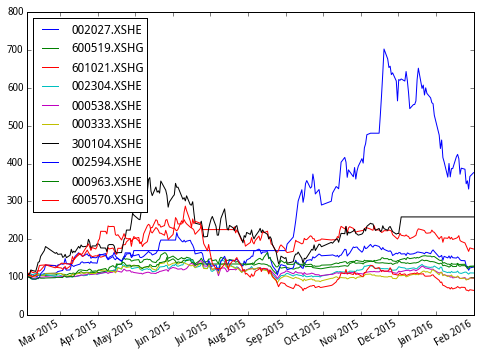

In [94]:
#比较一个各支股票的走势情况
(data/data.ix[0]*100).plot(figsize = (8,6));

In [95]:
#查看股票收益的分布情况
log_returns = np.log(data/data.shift(1))
log_returns = log_returns.dropna()
log_returns.head()

,002027.XSHE,600519.XSHG,601021.XSHG,002304.XSHE,000538.XSHE,000333.XSHE,300104.XSHE,002594.XSHE,000963.XSHE,600570.XSHG
2015-02-03,0.041622,0.020072,0.095408,0.026237,0.016706,0.016484,0.063960,0.006736,0.011616,0.042574
2015-02-04,-0.019371,-0.006302,-0.032149,0.036482,-0.017197,-0.002182,0.009864,-0.011948,-0.029589,-0.008339
2015-02-05,0.012151,-0.018162,0.095035,0.020416,-0.016999,-0.010983,0.095496,-0.014211,-0.027681,0.016292
2015-02-06,0.028573,0.003148,-0.042546,-0.035180,-0.017462,0.003858,-0.010463,-0.040568,-0.008254,-0.044545
2015-02-09,-0.040724,0.054043,-0.019036,0.039072,0.006416,0.015284,-0.021261,0.000000,-0.006693,0.038826


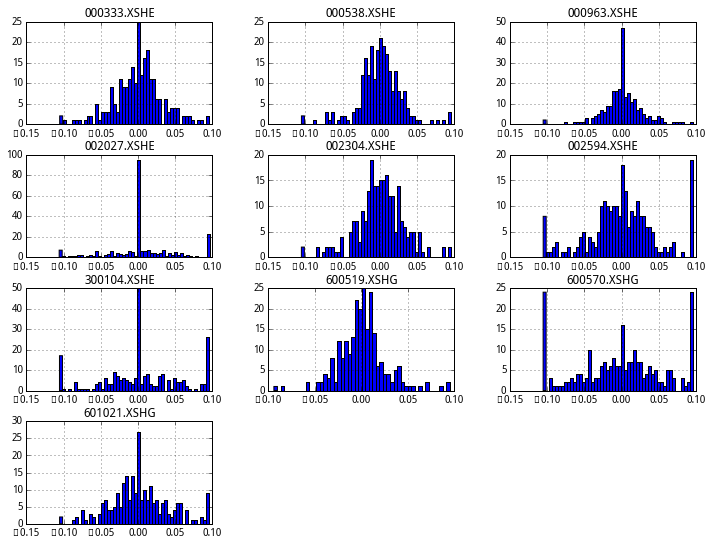

In [97]:
log_returns.hist(bins = 50, figsize = (12,9));

结论:收益明显不是正态分布,有肥尾现象。

### **2.2 蒙特卡洛模拟**

我们希望知道给定的一个股票池（证券组合）如何找到风险和收益平衡的位置。

下面通过一次蒙特卡洛模拟，产生大量随机的权重向量，并记录随机组合的预期收益和方差。

2.2.1 我们按每年252个交易日，用每日收益可以得到年化收益。

In [68]:
log_returns.mean() * 252 #得到年化收益

002027.XSHE    1.367156
600519.XSHG    0.261938
601021.XSHG    0.571751
002304.XSHE    0.102569
000538.XSHE   -0.040831
300104.XSHE    0.982001
002594.XSHE    0.241409
000963.XSHE    0.243941
600570.XSHG   -0.452787
dtype: float64

2.2.2 计算投资资产的协方差是构建资产组合过程的核心部分。我们可以运用pandas内置方法生产协方差矩阵。

In [69]:
log_returns.cov() * 252 #得到协方差矩阵

,002027.XSHE,600519.XSHG,601021.XSHG,002304.XSHE,000538.XSHE,300104.XSHE,002594.XSHE,000963.XSHE,600570.XSHG
002027.XSHE,0.503557,0.032138,0.128531,0.035666,0.069619,0.088816,0.101195,0.048296,0.194186
600519.XSHG,0.032138,0.158262,0.082084,0.136468,0.107755,0.070777,0.104729,0.069452,0.088239
601021.XSHG,0.128531,0.082084,0.390851,0.105530,0.090776,0.177960,0.159842,0.095297,0.226510
002304.XSHE,0.035666,0.136468,0.105530,0.250387,0.164660,0.141355,0.174451,0.094548,0.178022
000538.XSHE,0.069619,0.107755,0.090776,0.164660,0.206220,0.128379,0.176464,0.087424,0.168611
300104.XSHE,0.088816,0.070777,0.177960,0.141355,0.128379,0.730542,0.277690,0.078229,0.434820
002594.XSHE,0.101195,0.104729,0.159842,0.174451,0.176464,0.277690,0.533834,0.116846,0.310133
000963.XSHE,0.048296,0.069452,0.095297,0.094548,0.087424,0.078229,0.116846,0.172462,0.126318
600570.XSHG,0.194186,0.088239,0.226510,0.178022,0.168611,0.434820,0.310133,0.126318,0.846809


2.2.3 我们为每一个股票分配一个随机权重。

In [99]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.07877129,  0.11728734,  0.17456801,  0.07960339,  0.15916881,
        0.05274144,  0.09353782,  0.03720363,  0.15818885,  0.04892942])

2.2.4 可以得到在当前随机分配下的预期组合年化收益,组合方差和组合标准差

In [102]:
np.sum(log_returns.mean()*weights)*252

0.35562942923639623

In [103]:
np.dot(weights.T, np.dot(log_returns.cov()*252,weights))

0.140779057121977

In [105]:
np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()* 252,weights)))

0.37520535326934901

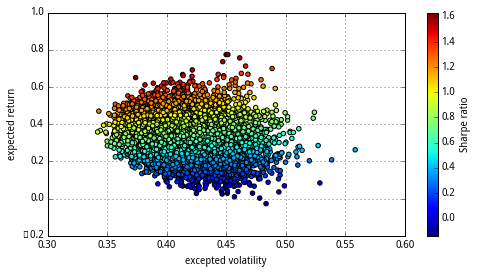

In [106]:
port_returns = []
port_variance = []
for p in range(10000):
    #随机为10支股票分配随机仓位
    weights = np.random.random(noa) 
    weights /= np.sum(weights) 
    #得到随机条件下组合预测年化收益记录
    port_returns.append(np.sum(log_returns.mean()*252*weights))
    #得到随机条件下组合标准差
    port_variance.append(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252, weights))))

port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

#无风险利率设定为4%
risk_free = 0.04
plt.figure(figsize = (8,4));
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker = 'o');
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio');

### **2.3 Sharp值最大化**

(Sharpe Ratio)为经风险调整后之绩效指标。夏普指数反映了单位风险基金净值增长率超过无风险收益率的程度。Sharp值最大化是组合收益最优化。

In [132]:
def statistics(weights):
    weights = np.array(weights)
    port_returns = np.sum(log_returns.mean()*weights)*252
    port_variance = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*252,weights)))
    return np.array([port_returns, port_variance, port_returns/port_variance])

#最小化夏普指数的负值
def min_sharpe(weights):
    return -statistics(weights)[2]

#约束是所有参数(权重)的总和为1。这可以用minimize函数的约定表达如下
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})

#我们还将参数值(权重)限制在0和1之间。这些值以多个元组组成的一个元组形式提供给最小化函数
bnds = tuple((0,1) for x in range(noa))

#优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
opts = sco.minimize(min_sharpe, noa*[1./noa,], method = 'SLSQP', bounds = bnds, constraints = cons)

opts

  status: 0
 success: True
    njev: 9
    nfev: 108
     fun: -2.1347913999575869
       x: array([  5.92194216e-01,   1.63875800e-01,   1.52536407e-02,
        -6.25557548e-16,   2.63461128e-17,   2.73652628e-16,
         2.28676343e-01,   1.12187820e-16,  -1.84097529e-16,
         1.87398925e-15])
 message: 'Optimization terminated successfully.'
     jac: array([  2.32458115e-05,  -4.07695770e-05,  -1.18613243e-05,
         4.37186539e-01,   8.19861293e-01,   8.01883221e-01,
        -2.99811363e-05,   7.05611169e-01,   9.93084908e-03,
         2.80743906e+00,   0.00000000e+00])
     nit: 9

In [133]:
#各个不同股票的权重
opts['x'].round(3) 

array([ 0.592,  0.164,  0.015, -0.   ,  0.   ,  0.   ,  0.229,  0.   ,
       -0.   ,  0.   ])

In [134]:
#预期收益率、预期波动率、最优夏普指数
statistics(opts['x']).round(3) 

array([ 1.086,  0.509,  2.135])

### **2.4 组合方差最小化**

组合方差最小化意味波动小，稳定性强。

In [135]:
#我们定义一个函数对方差进行最小化
def min_variance(weights):
    return statistics(weights)[1]

optv = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)

optv

  status: 0
 success: True
    njev: 7
    nfev: 84
     fun: 0.32228873994691271
       x: array([  1.25763137e-01,   4.03312618e-01,   2.47613475e-02,
         6.17995238e-18,   7.51343785e-02,  -2.50992803e-17,
         3.24015820e-02,   1.81603864e-18,   3.38626938e-01,
         6.45100293e-18])
 message: 'Optimization terminated successfully.'
     jac: array([ 0.32249353,  0.32210564,  0.32208595,  0.34474061,  0.32182401,
        0.35930406,  0.32246973,  0.37465306,  0.32253139,  0.41934536,  0.        ])
     nit: 7

In [136]:
#最小方差优化条件下，各个不同股票的权重
optv['x'].round(3)

array([ 0.126,  0.403,  0.025,  0.   ,  0.075, -0.   ,  0.032,  0.   ,
        0.339,  0.   ])

In [137]:
#最小方差优化条件下，组合预期收益率、波动率和夏普指数
statistics(optv['x']).round(3)

array([ 0.403,  0.322,  1.251])

In [138]:
#在不同目标收益率水平（target_returns）循环时，最小化的一个约束条件会变化。
target_returns = np.linspace(0.0,0.8,50)
target_variance = []
for tar in target_returns:
    cons = ({'type':'eq','fun':lambda x:statistics(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res = sco.minimize(min_variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
    target_variance.append(res['fun'])

target_variance = np.array(target_variance)

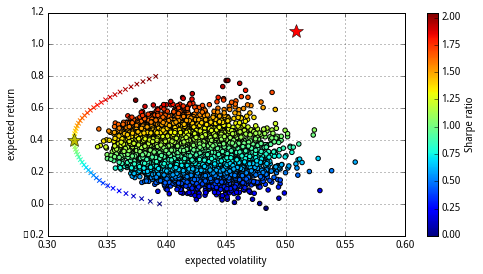

In [139]:
plt.figure(figsize = (8,4))
#圆圈：蒙特卡洛随机产生的组合分布
plt.scatter(port_variance, port_returns, c = port_returns/port_variance,marker = 'o')
#叉号：有效前沿
plt.scatter(target_variance,target_returns, c = target_returns/target_variance, marker = 'x')
#红星：标记最高sharpe组合
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize = 15.0)
#黄星：标记最小方差组合
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize = 15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio');